# Analsi StastModels

## Import Libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import plotly.express as px
import plotly.figure_factory as ff
import warnings
import math
import datetime
from datetime import datetime
warnings.filterwarnings('ignore')
from datetime import datetime
from datetime import timedelta
%matplotlib inline

import folium 
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

from datetime import datetime
import json 
from datetime import datetime

#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [3]:
case = pd.read_csv('Case.csv',index_col=0)
p_info = pd.read_csv('PatientInfo.csv',index_col=0)
time = pd.read_csv('Time.csv')
t_age = pd.read_csv('TimeAge.csv')
t_gender = pd.read_csv('TimeGender.csv')
t_province = pd.read_csv('TimeProvince.csv')
region = pd.read_csv('Region.csv',index_col=0)
weather = pd.read_csv('Weather.csv')
search = pd.read_csv('SearchTrend.csv')
floating = pd.read_csv('SeoulFloating.csv')
policy = pd.read_csv('Policy.csv',index_col=0)
population = pd.read_csv('Population_2020.csv')

# ETL
## (see "Analysis_ETL" for explanation!)

In [3]:
#Conversione da carattere a valore nil
case.latitude[(case.latitude=='-')]= np.nan
case.longitude[(case.longitude=='-')]= np.nan
case["latitude"]=case["latitude"].astype(float)
case["longitude"]=case["longitude"].astype(float)

In [4]:
p_info['age'] =p_info['age'].str.replace('s', '') #sostituisco la 's' a fine numero di età con il campo vuoto
p_info['age'] =p_info['age'].astype(float) #modifico il tipo da stringa a float
#dei valori mancanti ne faccio un fill con la media decade
media = p_info['age'].mean()
quoziente = int(media)/10
media_decade = quoziente*10
p_info['age']=p_info['age'].fillna(media_decade)
p_info['age'] =p_info['age'].astype(int) #modifico il tipo da stringa a int
p_city = p_info.city.isnull()

lista_prov = p_info[p_info['city'].isnull()].province.unique().tolist()

for prov in lista_prov:
    if prov=='Gwangju':
        moda_prov='Gwangju'
    else :
        moda_prov1=p_info[(p_info['province']==prov)].city.mode()
        moda_prov=moda_prov1.loc[0]
    i=0
    for cond in p_info['province']==prov:
        if cond:
            if (p_city[p_city.index[i]]).any():
                p_info.city[p_info.index[i]]=moda_prov
        i=i+1

In [5]:
p_info['infection_case']=p_info['infection_case'].fillna('unknown')
p_info['infected_by']=p_info['infected_by'].fillna('patient not found')
p_info.drop('contact_number', axis=1, inplace=True)

In [6]:
p_info[p_info['confirmed_date'].isnull()].index.tolist() #sulla connfirmed_date mancano tre date nel dataset

[6011000051, 6011000052, 6011000053]

In [7]:
p_info['confirmed_date']=p_info['confirmed_date'].fillna('2020-04-20')
dateFormatter = "%Y-%m-%d"
p_released= p_info.released_date.isnull()

somma=timedelta(0)
k=0

for i in p_info.index:
    if not p_released[i].any():
        data1 = datetime.strptime(p_info.released_date[i], dateFormatter)
        data2 = datetime.strptime(p_info.confirmed_date[i], dateFormatter)
        diff = data1-data2
        somma = somma + diff
        k = k+1

media_rilascio = somma/k 
media_rilascio_giorni = timedelta(media_rilascio.days)
p_state = (p_info.state == 'released') #abbiamo riempito solo le righe 'released'

for i in p_info.index: 
    if p_state[i].any():
        if p_released[i].any():
            data_confirmed = datetime.strptime(p_info.confirmed_date[i], dateFormatter)
            p_info.released_date[i] = data_confirmed + media_rilascio_giorni
dateFormatter = "%Y-%m-%d"
p_deceased= p_info.deceased_date.isnull()

somma=timedelta(0)
k=0

for i in p_info.index:
    if not p_deceased[i].any():
        data1 = datetime.strptime(p_info.deceased_date[i], dateFormatter)
        data2 = datetime.strptime(p_info.confirmed_date[i], dateFormatter)
        diff_deceased = data1-data2
        somma = somma + diff
        k = k+1

media_morte = somma/k
p_info['released_date']= pd.to_datetime(p_info['released_date'])
p_info['confirmed_date']= pd.to_datetime(p_info['confirmed_date'])
p_info['deceased_date']= pd.to_datetime(p_info['deceased_date'])
p_info['symptom_onset_date']=pd.to_datetime(p_info['symptom_onset_date'], errors='coerce') #coerce serve per togliere un valore mismatched nel dataframe

In [8]:
time['date']= pd.to_datetime(time['date'])
t_age['date']= pd.to_datetime(t_age['date'])
t_age['age'] =t_age['age'].str.replace('s', '') #sostituisco la 's' a fine numero di età con il campo vuoto
t_age['age'] =t_age['age'].astype(int) #modifico il tipo da stringa a float
t_gender['date']= pd.to_datetime(t_gender['date'])
t_province['date']= pd.to_datetime(t_province['date'])

In [9]:
weather['date']= pd.to_datetime(weather['date'])
media_prov_avg = weather[(weather['province']==prov)].avg_temp.mean()
weather_avg_temp = weather.avg_temp.isnull()

lista_prov1 = weather['province'].unique().tolist()
i=0

for wat in weather_avg_temp:
    if wat:
        prov = weather.province[i]
        media_prov_avg = weather[(weather['province']==prov)].avg_temp.mean()
        weather.avg_temp[i] = media_prov_avg
    i=i+1
media_prov_min = weather[(weather['province']==prov)].min_temp.mean()
weather_min_temp = weather.min_temp.isnull()

lista_prov1 = weather['province'].unique().tolist()
i=0

for wat in weather_min_temp:
    if wat:
        prov = weather.province[i]
        media_prov_min = weather[(weather['province']==prov)].min_temp.mean()
        weather.min_temp[i] = media_prov_min
    i=i+1
media_prov_max = weather[(weather['province']==prov)].max_temp.mean()
weather_max_temp = weather.max_temp.isnull()

lista_prov1 = weather['province'].unique().tolist()
i=0

for wat in weather_max_temp:
    if wat:
        prov = weather.province[i]
        media_prov_max = weather[(weather['province']==prov)].max_temp.mean()
        weather.max_temp[i] = media_prov_max
    i=i+1
media_prov_max_wind = weather[(weather['province']==prov)].max_wind_speed.mean()
weather_max_wind_speed = weather.max_wind_speed.isnull()

lista_prov1 = weather['province'].unique().tolist()
i=0

for wat in weather_max_wind_speed:
    if wat:
        prov = weather.province[i]
        media_prov_max_wind = weather[(weather['province']==prov)].max_wind_speed.mean()
        weather.max_wind_speed[i] = media_prov_max_wind
    i=i+1
media_prov_most = weather[(weather['province']==prov)].most_wind_direction.mean()
weather_most_wind_direction = weather.most_wind_direction.isnull()

lista_prov1 = weather['province'].unique().tolist()
i=0

for wat in weather_most_wind_direction:
    if wat:
        prov = weather.province[i]
        media_prov_most = weather[(weather['province']==prov)].most_wind_direction.mean()
        weather.most_wind_direction[i] = media_prov_most
    i=i+1
media_prov_avg_r = weather[(weather['province']==prov)].avg_relative_humidity.mean()
weather_avg_relative_humidity= weather.avg_relative_humidity.isnull()

lista_prov1 = weather['province'].unique().tolist()
i=0

for wat in weather_avg_relative_humidity:
    if wat:
        prov = weather.province[i]
        media_prov_avg_r = weather[(weather['province']==prov)].avg_relative_humidity.mean()
        weather.avg_relative_humidity[i] = media_prov_avg_r
    i=i+1
search['date']= pd.to_datetime(search['date'])
floating['date']= pd.to_datetime(floating['date'])
policy['detail']=policy['detail'].fillna('not detail')
policy['start_date']= pd.to_datetime(policy['start_date'])
policy['end_date']=policy['end_date'].fillna('2020-07-01')
policy['end_date']= pd.to_datetime(policy['end_date'])
population.rename(columns={'Unnamed: 0': 'Province', 'Unnamed: 1': 'Origin'}, inplace=True)
population['Province'] =population['Province'].str.replace('0', '-')
for column in population.columns[2:]:
    population[column] =population[column].str.replace(',', '')
    population[column] =population[column].astype(int)

We begin analyzing the time series from the $ Time.csv $ dataset.
In this file there are the cumulative data, day by day, of tests, positives, negatives, healed and deceased, in the time span from 20 January 2020 to 30 June 2020.
In reality, the cumulative value of the various variables is not required for the temporal analyzes, but the daily value is required. To do this, simply subtract from each row the cumulative value present in the previous row, i.e. the previous day, thus estimating the daily increases.

In particular, the most significant variable on which to make a forecast is the number of positives, but graphing this trend it is clear that from April onwards the number of infected has always remained constant at a very low value, due to the excellent policy anticovid fielded by the South Korean government.

# Analysis Statsmodels

In [10]:
t_province["confirmed_g"]=0
t_province["confirmed_g"].loc[3]=1
t_province["released_g"]=0
t_province["deceased_g"]=0
for i in t_province.index:
    if i>17:
        t_province["confirmed_g"].loc[i]=t_province["confirmed"].loc[i]-t_province["confirmed"].loc[i-17]
        t_province["released_g"].loc[i]=t_province["released"].loc[i]-t_province["released"].loc[i-17]
        t_province["deceased_g"].loc[i]=t_province["deceased"].loc[i]-t_province["deceased"].loc[i-17]
t_province.drop(['confirmed','released','deceased'], axis=1, inplace=True)
t_province.info()
t_province.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2771 non-null   datetime64[ns]
 1   time         2771 non-null   int64         
 2   province     2771 non-null   object        
 3   confirmed_g  2771 non-null   int64         
 4   released_g   2771 non-null   int64         
 5   deceased_g   2771 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 130.0+ KB


,date,time,province,confirmed_g,released_g,deceased_g
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0


In [11]:
time["test_g"]=1
time["confirmed_g"]=1
time['negative_g']=0
time['released_g']=0
time["deceased_g"]=0
for i in time.index:
    if i!=0:
        time["test_g"].loc[i]=time["test"].loc[i]-time["test"].loc[i-1]
        time["confirmed_g"].loc[i]=time["confirmed"].loc[i]-time["confirmed"].loc[i-1]
        time['negative_g'].loc[i]=time['negative'].loc[i]-time['negative_g'].loc[i-1]
        time['released_g'].loc[i]=time['released'].loc[i]-time['released'].loc[i-1]
        time["deceased_g"].loc[i]=time["deceased"].loc[i]-time["deceased"].loc[i-1]
        
time.index= time.date
time.drop(['test', 'confirmed', 'negative', 'released', 'deceased', 'time','date'], axis=1, inplace=True)
time.head()
time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2020-01-20 to 2020-06-30
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   test_g       163 non-null    int64
 1   confirmed_g  163 non-null    int64
 2   negative_g   163 non-null    int64
 3   released_g   163 non-null    int64
 4   deceased_g   163 non-null    int64
dtypes: int64(5)
memory usage: 7.6 KB


<AxesSubplot:xlabel='date'>

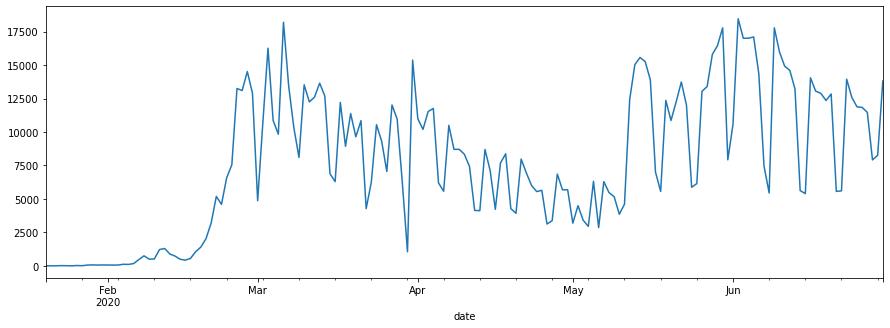

In [12]:
test = time.test_g #[time.index> pd.to_datetime('2020-02-25')]
test.plot(figsize=(15, 5))

Instead, by graphically representing the progress of the tests, it can be seen that they have remained high numbers, and how they also have a strong weekly seasonality, due to the fact that on Saturday and Sunday the number of swabs carried out is much less than the others. days.

<AxesSubplot:xlabel='date'>

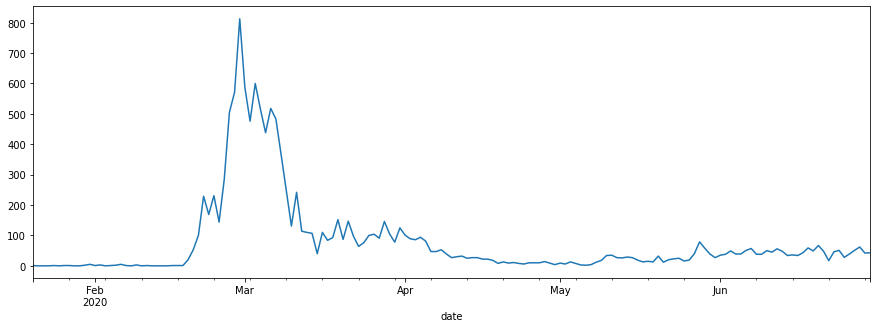

In [13]:
contagi = time.confirmed_g
contagi.plot(figsize=(15, 5))

In [14]:
result = adfuller(test)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print(result)

ADF Statistic: -4.534839
p-value: 0.000170
(-4.53483930673814, 0.00017001925947810972, 0, 162, {'1%': -3.471374345647024, '5%': -2.8795521079291966, '10%': -2.5763733302850174}, nan)


The next step is to identify if the model needs input from the AR component. You can find out the required AR order by inspecting the Partial Autocorrelation (PACF) graph.

Any autocorrelation in a stationary series can be explained by adding a sufficient number of AR terms.
Then, initially we take the order of the AR terms equal to the number of lags exceeding the limit in the PACF chart.

<AxesSubplot:xlabel='date'>

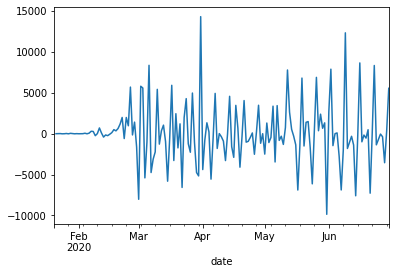

In [15]:
test.diff().plot()

It can be observed that PACF lag 1 is quite significant as it is well above the limit area, which is not the case for lag 2.
So for now we fix the term p equal to 1.

Just as you looked at the PACF chart for the number of AR terms, you can look at the ACF chart for the number of MA terms.
The ACF is the self-correlation plot and indicates how many MA terms are needed to remove any autocorrelation in the stationary series.

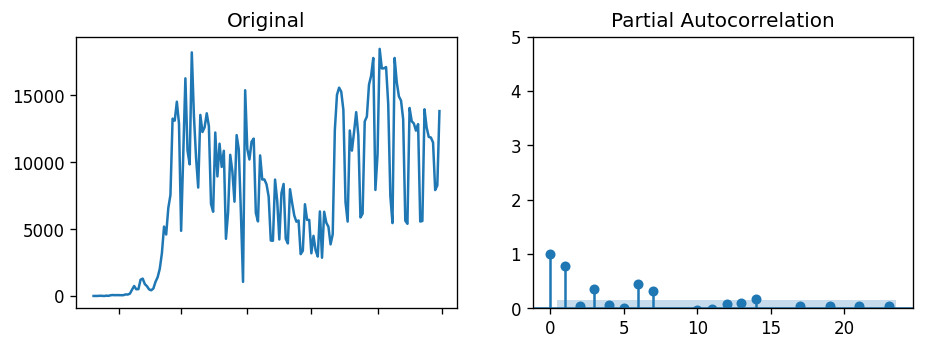

In [16]:
plt.rcParams.update({'figure.figsize': (9,3), 'figure.dpi': 120})
fig, axes= plt.subplots(1,2)
axes[0].plot(test);
axes[0].set_title('Original')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')

axes[1].set(ylim=(0,5))
plot_pacf(test, ax=axes[1])

plt.show()


il termine p sarà uguale a 1 poichè solo il lag1 è sopra il limite.

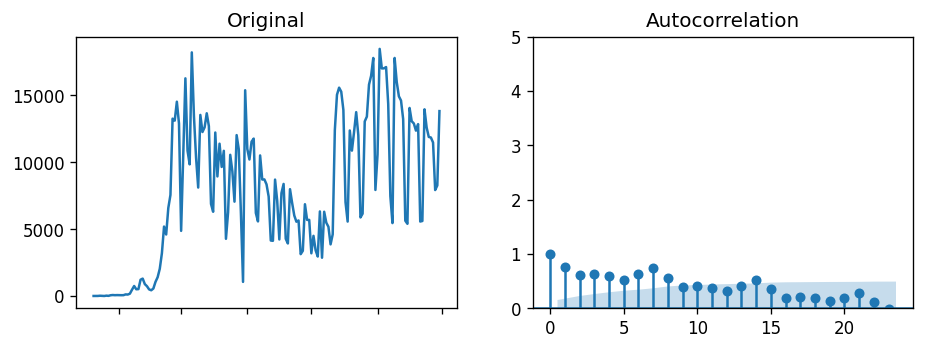

In [17]:
fig, axes= plt.subplots(1,2)
axes[0].plot(test);
axes[0].set_title('Original')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')

axes[1].set(ylim=(0,5))
plot_acf(test, ax=axes[1])

plt.show()

It can be immediately observed that the terms AR1 and MA1 are very good, since they have a very high level of significance (P> | z | << 0.05).

The residuals can now be plotted to make sure there are no particular patterns (ie we look for mean and constant variance).

In [19]:
model= ARIMA(test, order=(1,0,1))
model_fit= model.fit()
print(model_fit.summary())
#ax = plt.gca()
#plt.plot(test)
#plt.plot(model_fit.fittedvalues, color='red')
#ax.legend(['test giornalieri', 'Forecast'])


                              ARMA Model Results                              
Dep. Variable:                 test_g   No. Observations:                  163
Model:                     ARMA(1, 1)   Log Likelihood               -1550.423
Method:                       css-mle   S.D. of innovations           3258.003
Date:                Mon, 28 Dec 2020   AIC                           3108.846
Time:                        09:50:08   BIC                           3121.221
Sample:                    01-20-2020   HQIC                          3113.870
                         - 06-30-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7351.5069   2331.525      3.153      0.002    2781.802    1.19e+04
ar.L1.test_g     0.9592      0.033     29.446      0.000       0.895       1.023
ma.L1.test_g    -0.5840      0.123     -4.73

c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


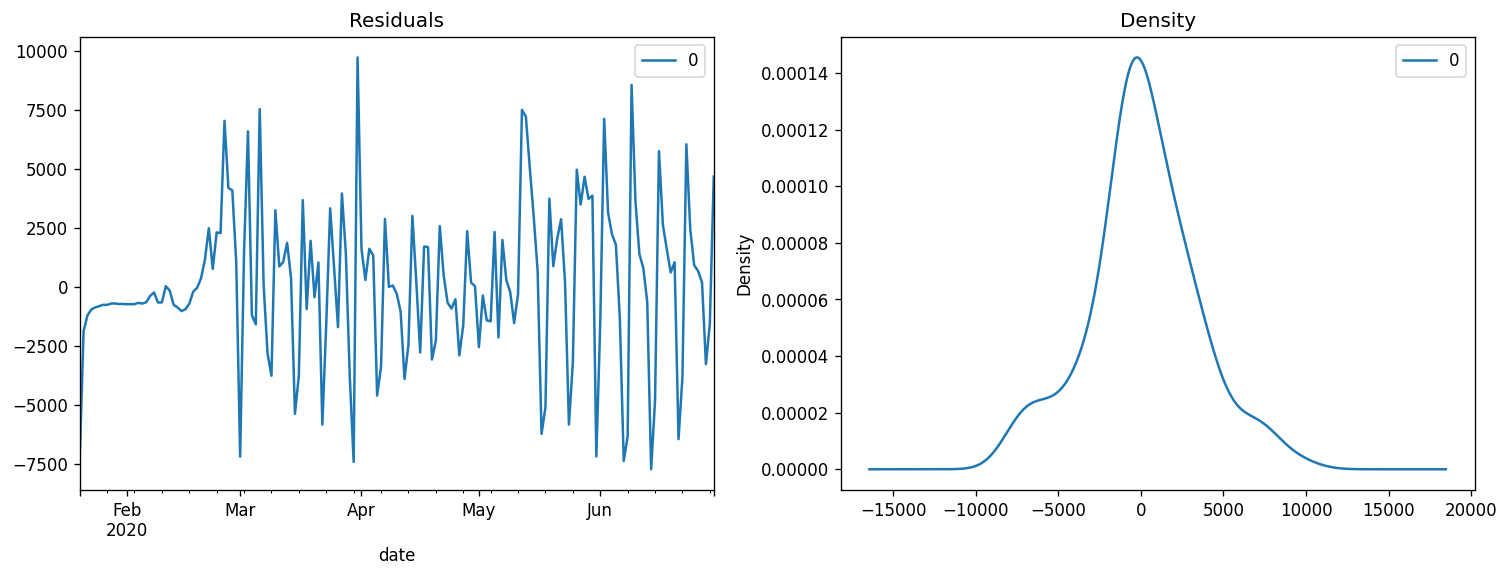

In [20]:
residuals= pd.DataFrame(model_fit.resid)
fig, ax= plt.subplots(1,2,figsize=(15, 5))
residuals.plot(title="Residuals", ax= ax[0])
residuals.plot(kind= 'kde', title= 'Density', ax=ax[1])
plt.show()

The results obtained appear to be good, since the residual errors appear to be contained with an average close to zero and a uniform variance.

Finally, the entire time series and the model forecast data are plotted together.

<Figure size 1800x960 with 0 Axes>

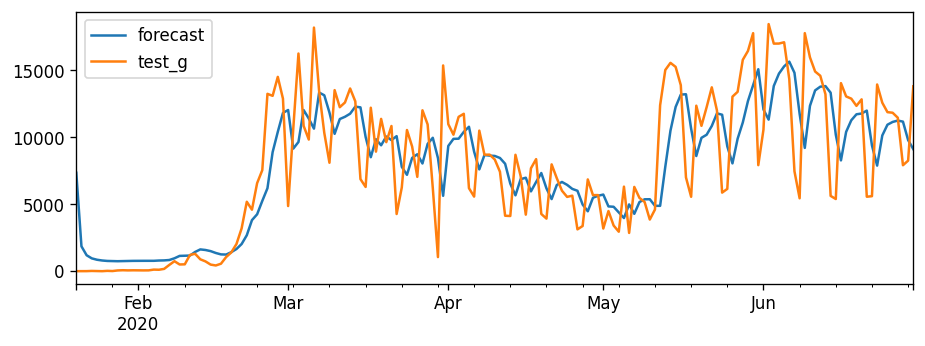

In [21]:
plt.figure(figsize=(15,8)) 
model_fit.plot_predict(dynamic=False)
 
plt.show()

In [22]:
#facciamo le divisioni del dataset con percentuali 85-15
train= test[:pd.to_datetime('2020-06-06')]
test_f= test[pd.to_datetime('2020-06-07'):]

The results obtained appear to be good, since the residual errors appear to be contained with an average close to zero and a uniform variance.

Finally, the entire time series and the model forecast data are plotted together.

c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


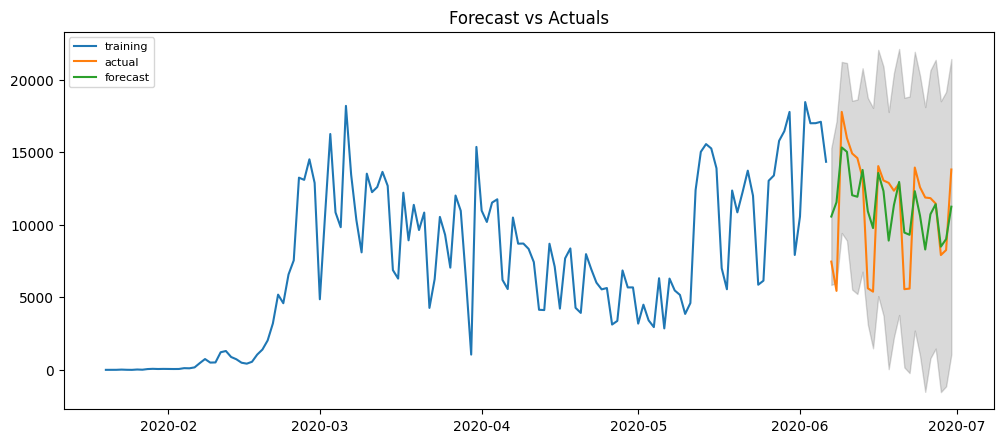

In [24]:
model= ARIMA(train, order=(3,0,10))
fitted= model.fit(disp=-1)

fc, se, conf= fitted.forecast(24, alpha=0.05)

fc_series= pd.Series(fc, index= test_f.index)
lower_series= pd.Series(conf[:, 0], index= test_f.index)
upper_series= pd.Series(conf[:, 1], index= test_f.index)

plt.figure(figsize= (12,5), dpi= 100)
plt.plot(train, label='training')
plt.plot(test_f, label = 'actual')
plt.plot(fc_series, label ='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize= 8)
plt.show()

In [25]:
# Construct the model
mod = sm.tsa.SARIMAX(test, order=(1,0,1), seasonal_order=(1, 0, 1, 7))
# Estimate the parameters
res = mod.fit()

print(res.summary())

c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                            test_g   No. Observations:                  163
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1486.962
Date:                           Mon, 28 Dec 2020   AIC                           2983.923
Time:                                   09:51:55   BIC                           2999.392
Sample:                               01-20-2020   HQIC                          2990.203
                                    - 06-30-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9251      0.027     34.394      0.000       0.872       0.978
ma.L1         -0.3741      0.068     -5.541

c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The values of the P terms are all << 0.05, which is great. In fact, if you graph the forecast made, you immediately see that the forecast is excellent.
In this case, the entire time series is used as the training set, and therefore there are no testing values with which to compare the forecast.

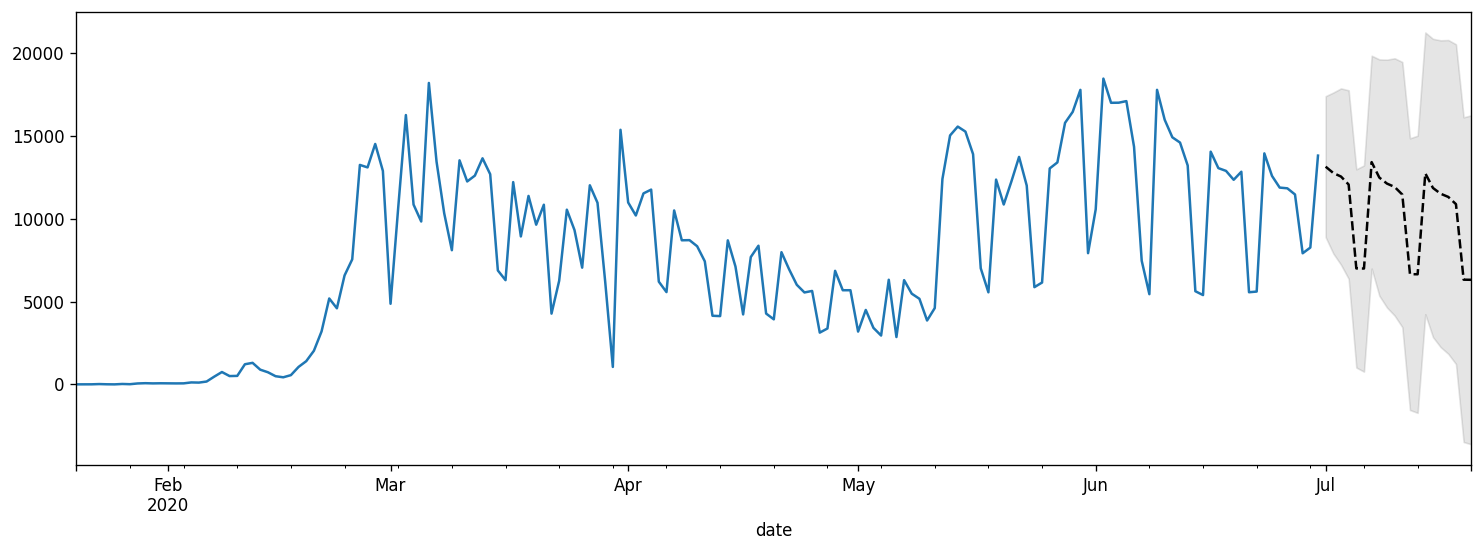

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
test.plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(steps=20).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [28]:
# Construct the model
mod = sm.tsa.SARIMAX(train, order=(1,0,1), seasonal_order=(1, 0, 1, 7))
# Estimate the parameters
res = mod.fit()

print(res.summary())

c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                            test_g   No. Observations:                  139
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1274.020
Date:                           Mon, 28 Dec 2020   AIC                           2558.040
Time:                                   09:52:07   BIC                           2572.713
Sample:                               01-20-2020   HQIC                          2564.003
                                    - 06-06-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9345      0.027     34.425      0.000       0.881       0.988
ma.L1         -0.3776      0.073     -5.178

So we do the same division we did earlier, for the training and test sets.
In this way we can perform an Out-of-Time Cross-Validation and compare our results with the real values.
Also in this case we construct the SARIMA model with the orders of p, d and q = 1, 0, 1, the orders P, D, Q = 1, 0, 1 and m = 7.

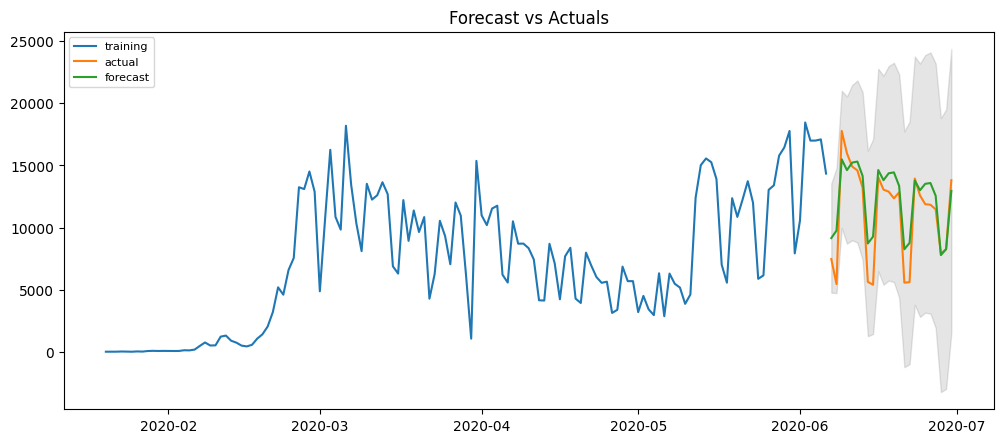

In [29]:
fcast = res.get_forecast(steps=24).summary_frame()

plt.figure(figsize= (12,5), dpi= 100)
plt.plot(train, label='training')
plt.plot(test_f, label = 'actual')
plt.plot(fcast['mean'], label ='forecast')
plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize= 8)
plt.show()

In [30]:
#floating.set_index(['date', 'hour'], inplace= True)
floating_ragg= floating.groupby(by=['date', 'hour'],as_index=True).sum()
floating_ragg1= floating.groupby(by=['date', 'hour'],as_index=False).sum()
spostamenti= floating_ragg.drop('birth_year', axis=1)
spostamenti1= floating_ragg1.drop(['birth_year','date', 'hour'], axis=1)

Nel dataset $SeoulFloating.csv$ vi sono informazioni sul numero di persone in movimento e che si stanno spostando all'interno della provincia di Seoul. In particolare tale informazione viene raccolta ora per ora, dividendo il numero del $floating$ $people$ per fascia di età, per sesso e per città all'interno della provincia.
Per rappresentare un'unica serie temporale si vanno allora a raggruppare i valori di ogni categoria, ora per ora, creando così un unico valore che rappresenta l'intera popolazione in movimento all'interno della provincia di Seoul.

[Text(-500.0, 0, '(2020-05-10 00:00:00, 20)'),
 Text(0.0, 0, '(2020-01-01 00:00:00, 0)'),
 Text(500.0, 0, '(2020-01-21 00:00:00, 20)'),
 Text(1000.0, 0, '(2020-02-11 00:00:00, 16)'),
 Text(1500.0, 0, '(2020-03-03 00:00:00, 12)'),
 Text(2000.0, 0, '(2020-03-25 00:00:00, 8)'),
 Text(2500.0, 0, '(2020-04-15 00:00:00, 4)'),
 Text(3000.0, 0, '(2020-05-06 00:00:00, 0)'),
 Text(3500.0, 0, '(2020-05-26 00:00:00, 21)'),
 Text(4000.0, 0, '')]

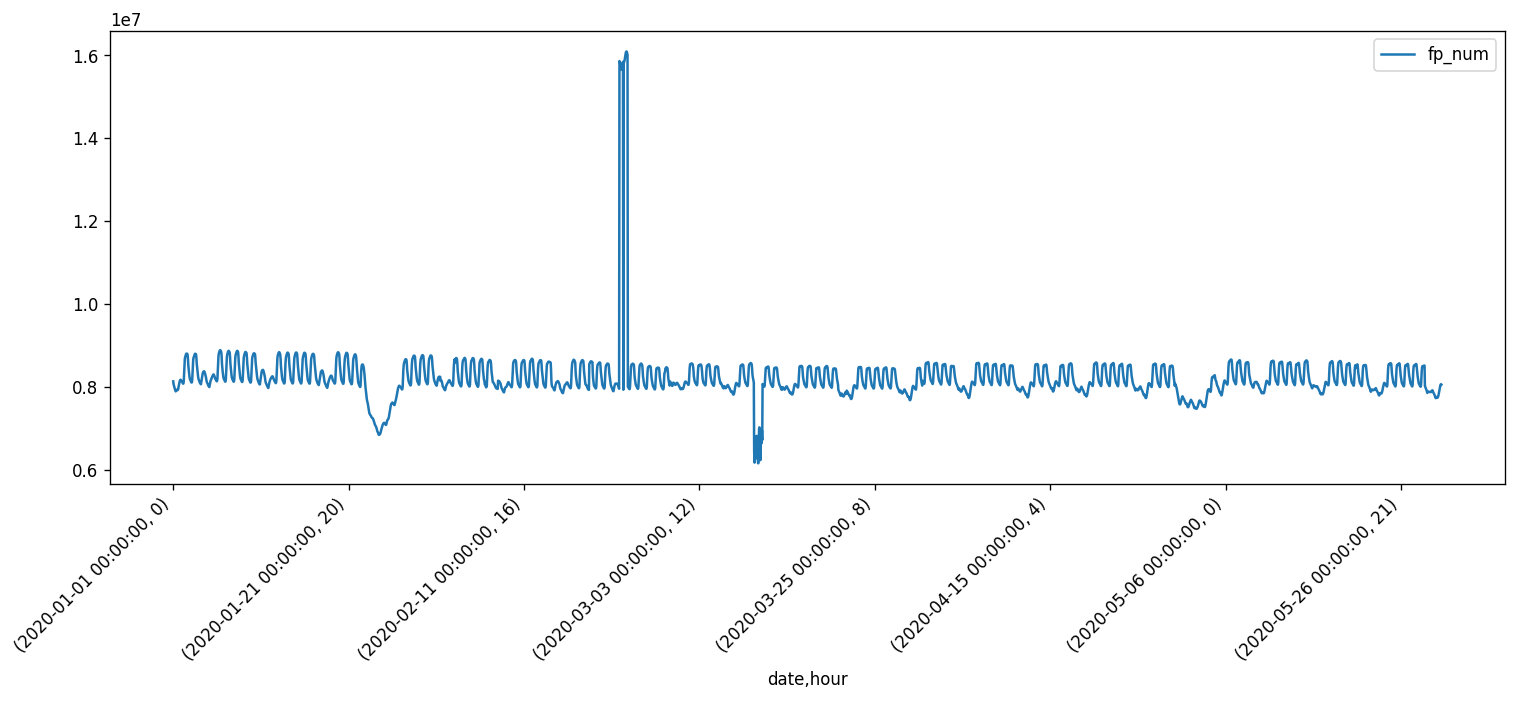

In [31]:
ax=spostamenti.plot(figsize=(15, 5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [32]:
spostamenti[spostamenti.fp_num==spostamenti.fp_num.max()]

,,fp_num
date,hour,
2020-02-23,20,16096140


Just in those days in South Korea there was a gathering in Daegu at the Church of Jesus Shincheonji, the Temple of the Tabernacle of the Testimony, which moved huge masses of people from all over Korea.

If you try to focus and enlarge the trend in a period following this peak, you can observe the presence of a double seasonality, that is, a daily one with a decrease in movements at night and a weekly one with a decrease during the weekend. This is precisely because South Korea is a very advanced country and people are little addicted to entertainment and leisure, and often they leave the house only to go to work.

[Text(-100.0, 0, '(2020-04-11 00:00:00, 20)'),
 Text(0.0, 0, '(2020-03-25 00:00:00, 0)'),
 Text(100.0, 0, '(2020-03-29 00:00:00, 4)'),
 Text(200.0, 0, '(2020-04-02 00:00:00, 8)'),
 Text(300.0, 0, '(2020-04-06 00:00:00, 12)'),
 Text(400.0, 0, '(2020-04-10 00:00:00, 16)'),
 Text(500.0, 0, '(2020-04-14 00:00:00, 20)'),
 Text(600.0, 0, '')]

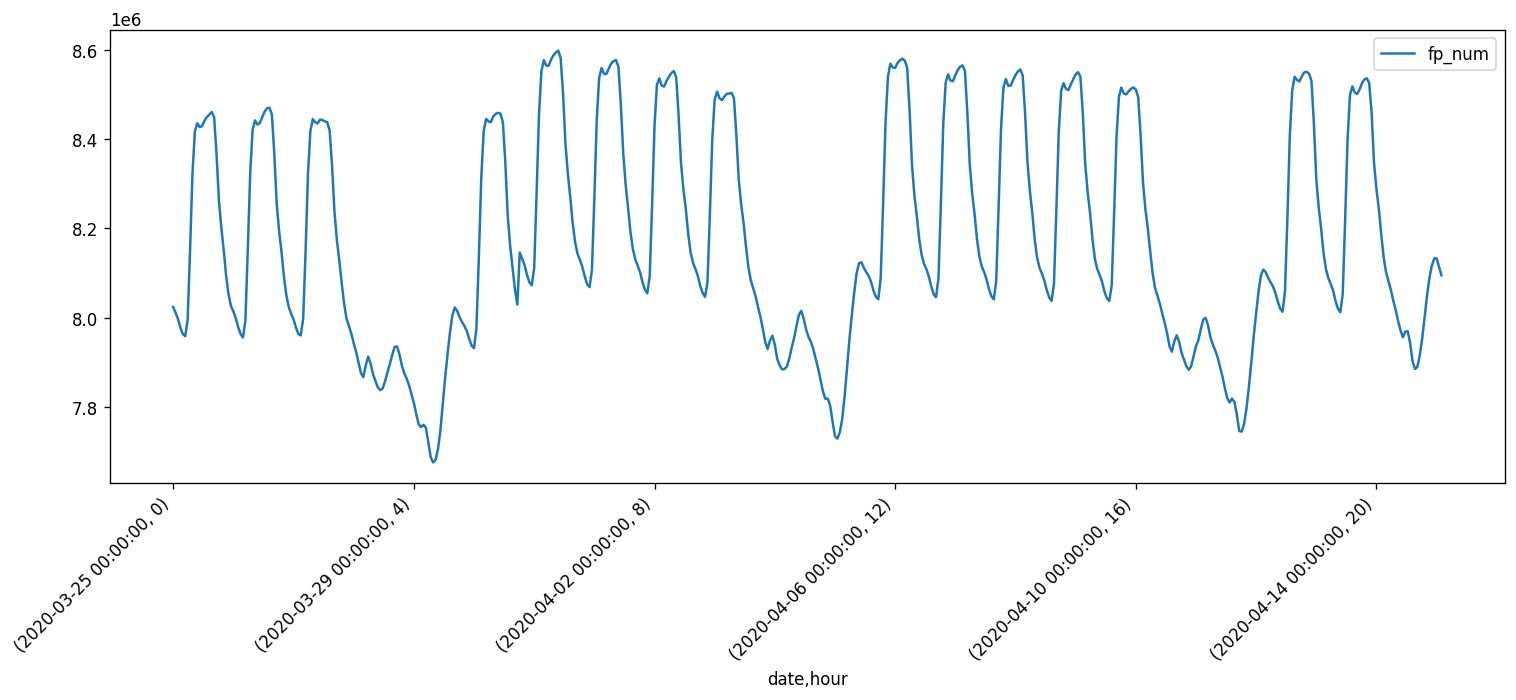

In [33]:
ax= spostamenti[(spostamenti.index.get_level_values(0)>= pd.to_datetime('2020-03-25')) & (spostamenti.index.get_level_values(0)<= pd.to_datetime('2020-04-15'))].plot(figsize=(15, 5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

We now start with the construction of the ARIMA model.
As previously done, the first step is to determine if the series is stationary or not, through the ADF test.

In [34]:
result = adfuller(spostamenti)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print(result)

ADF Statistic: -9.010520
p-value: 0.000000
(-9.010520203341361, 6.143658136568553e-15, 30, 3585, {'1%': -3.432175380325744, '5%': -2.862346550668757, '10%': -2.5671993399002897}, 99236.23979813841)


From the result we learn that the p-value is almost zero and << 0.05, therefore the series is stationary and does not need to be differentiated: the order d is then equal to 0.
 
  We then move on to the calculation of the order of the AR terms. To do this, the partial autocorrelation graph is constructed.

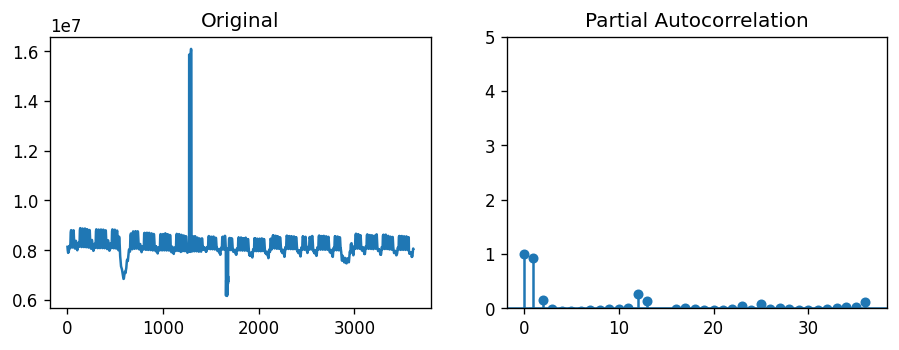

In [35]:
plt.rcParams.update({'figure.figsize': (9,3), 'figure.dpi': 120})
fig, axes= plt.subplots(1,2)
axes[0].plot(spostamenti1)
axes[0].set_title('Original')


axes[1].set(ylim=(0,5))
plot_pacf(spostamenti1, ax=axes[1])

plt.show()

From the partial autocorrelation graph it can be observed that the first two lags are above the threshold, therefore the term p equal to 2 is chosen.

Finally, the autocorrelation graph is used to calculate the number of MA terms.

il termine p sarà uguale a 1-2 poichè solo il lag1 è sopra il limite

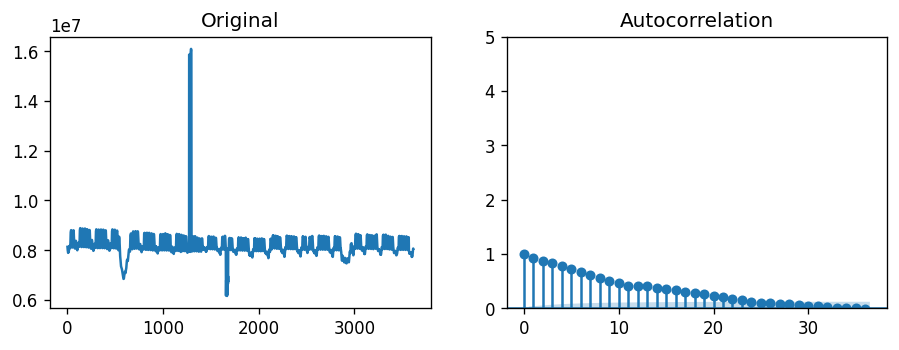

In [36]:
fig, axes= plt.subplots(1,2)
axes[0].plot(spostamenti1)
axes[0].set_title('Original')

axes[1].set(ylim=(0,5))
plot_acf(spostamenti1, ax=axes[1])

plt.show()

per ora scegliamo il termine q pari a 20

In [37]:
spostamenti1.tail(3)

,fp_num
3613,8058660
3614,8063190
3615,8052730


c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


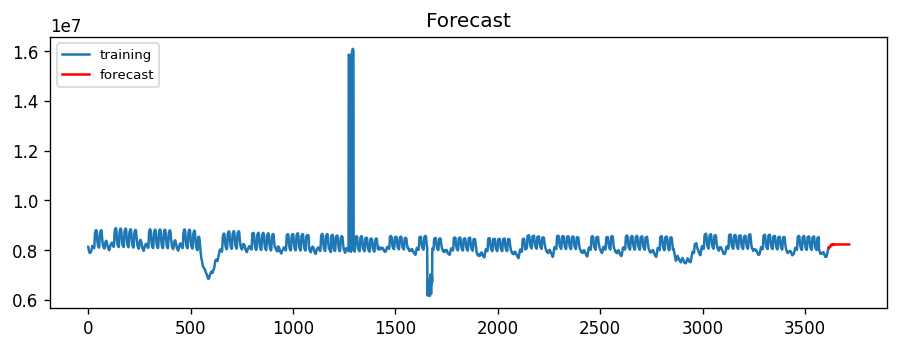

In [39]:
model= ARIMA(spostamenti, order=(2,0,20))
fitted= model.fit(disp=-1)

x = fitted.predict(start=(3615), end=(3715), dynamic=False)

plt.plot(spostamenti1[:3615], label='training')
plt.plot(x, color='r', label ='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize= 8)
plt.show()

In [40]:
model= ARIMA(spostamenti, order=(1,0,1))
model_fit= model.fit()
print(model_fit.summary())
#ax = plt.gca()
#plt.plot(test)
#plt.plot(model_fit.fittedvalues, color='red')
#ax.legend(['test giornalieri', 'Forecast'])


c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                              ARMA Model Results                              
Dep. Variable:                 fp_num   No. Observations:                 3616
Model:                     ARMA(1, 1)   Log Likelihood              -50299.353
Method:                       css-mle   S.D. of innovations         265935.913
Date:                Mon, 28 Dec 2020   AIC                         100606.706
Time:                        09:58:51   BIC                         100631.478
Sample:                             0   HQIC                        100615.532
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.228e+06   6.86e+04    119.906      0.000    8.09e+06    8.36e+06
ar.L1.fp_num     0.9461      0.006    164.817      0.000       0.935       0.957
ma.L1.fp_num    -0.1591      0.017     -9.56

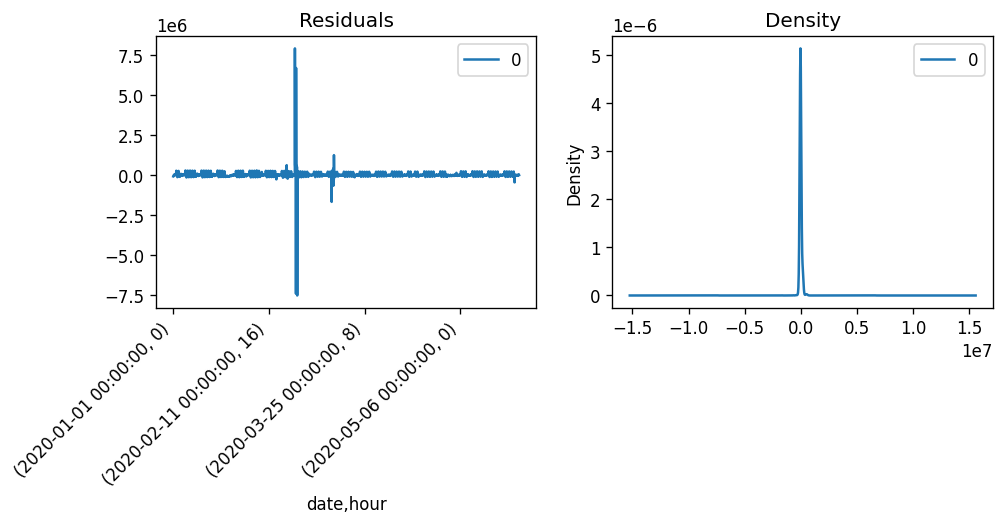

In [41]:
residuals= pd.DataFrame(model_fit.resid)
fig, ax= plt.subplots(1,2)
residuals.plot(title="Residuals", ax= ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
residuals.plot(kind= 'kde', title= 'Density', ax=ax[1])

plt.show()

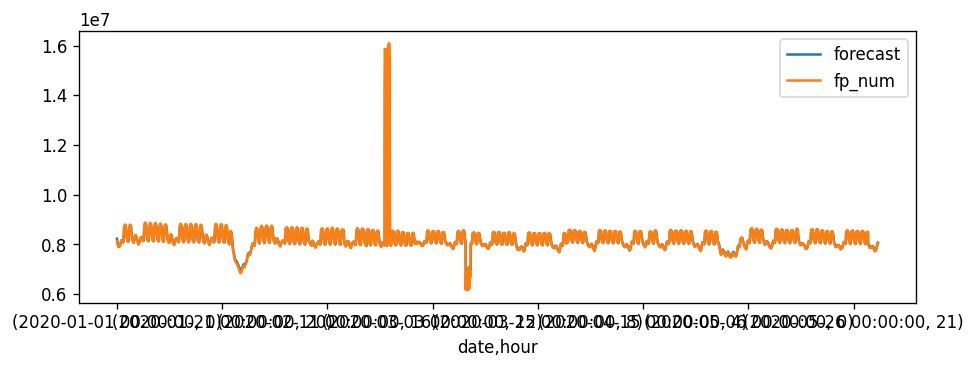

In [42]:
model_fit.plot_predict(dynamic=False)
plt.show()


In [43]:
spostamenti1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3616 entries, 0 to 3615
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   fp_num  3616 non-null   int64
dtypes: int64(1)
memory usage: 56.5 KB


In [44]:
train= spostamenti1[:3074]
test= spostamenti1[3075:]

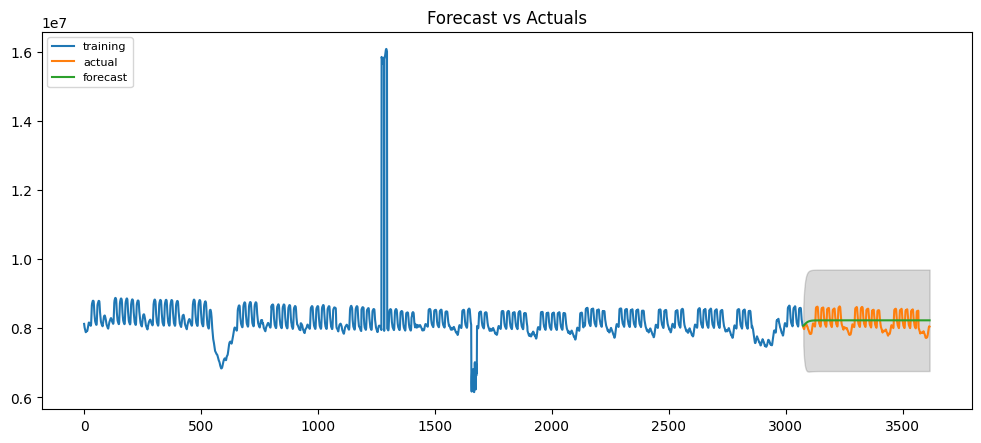

In [46]:
model= ARIMA(train, order=(3,0,1))
fitted= model.fit(disp=-1)

fc, se, conf= fitted.forecast(541, alpha=0.05)

fc_series= pd.Series(fc, index= test.index)
lower_series= pd.Series(conf[:, 0], index= test.index)
upper_series= pd.Series(conf[:, 1], index= test.index)

plt.figure(figsize= (12,5), dpi= 100)
plt.plot(train, label='training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label ='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize= 8)
plt.show()

In [61]:
# Construct the model
mod = sm.tsa.SARIMAX(train, order=(2,0,10), seasonal_order=(1, 0, 1, 24), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

c:\users\claudio\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                       
Dep. Variable:                                fp_num   No. Observations:                 3074
Model:             SARIMAX(2, 0, 10)x(1, 0, [1], 24)   Log Likelihood              -44223.501
Date:                               Mon, 28 Dec 2020   AIC                          88479.002
Time:                                       10:49:43   BIC                          88575.494
Sample:                                            0   HQIC                         88513.667
                                              - 3074                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.196e+05   4.95e-10   1.45e+15      0.000     7.2e+05     7.2e+05
ar.L1      

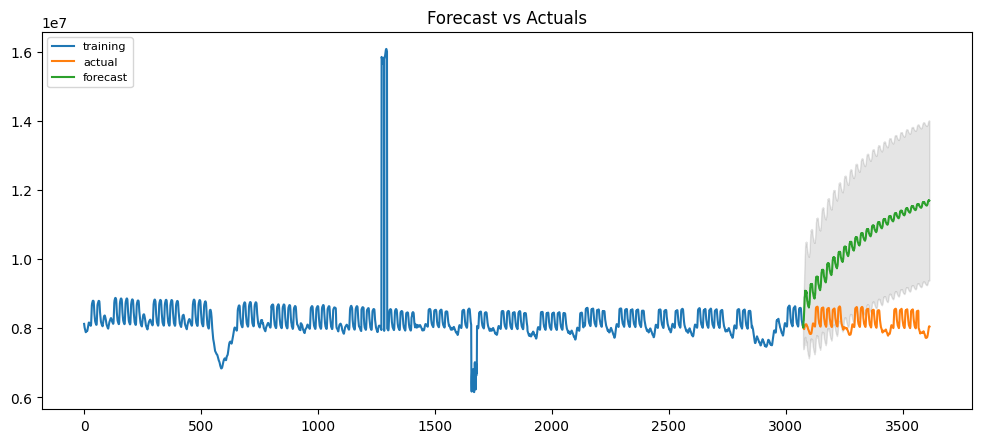

In [62]:
fcast = res.get_forecast(steps=541).summary_frame()

plt.figure(figsize= (12,5), dpi= 100)
plt.plot(train, label='training')
plt.plot(test, label = 'actual')
plt.plot(fcast['mean'], label ='forecast')
plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize= 8)
plt.show()


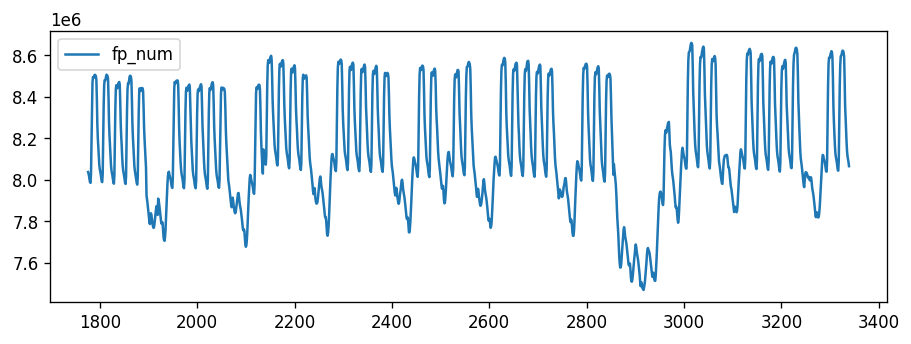

In [65]:
train= spostamenti1[1776:3340]
test= spostamenti1[3341:]
train.plot()
plt.show()

In [66]:
result = adfuller(spostamenti[1776:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print(result)

ADF Statistic: -4.521882
p-value: 0.000179
(-4.521882171288332, 0.000179491909860238, 0, 1839, {'1%': -3.4339108761687758, '5%': -2.8631129277746887, '10%': -2.5676073721917216}, nan)


d sarà uguale a 0

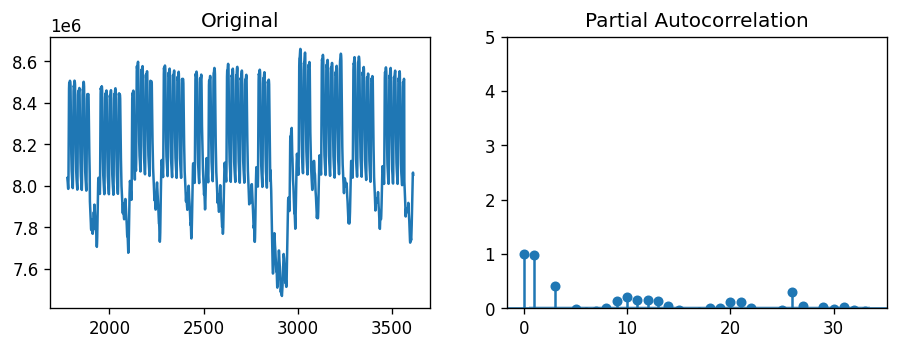

In [67]:
plt.rcParams.update({'figure.figsize': (9,3), 'figure.dpi': 120})
fig, axes= plt.subplots(1,2)
axes[0].plot(spostamenti1[1776:])
axes[0].set_title('Original')


axes[1].set(ylim=(0,5))
plot_pacf(spostamenti1[1776:], ax=axes[1])

plt.show()

p sarà uguale a 2

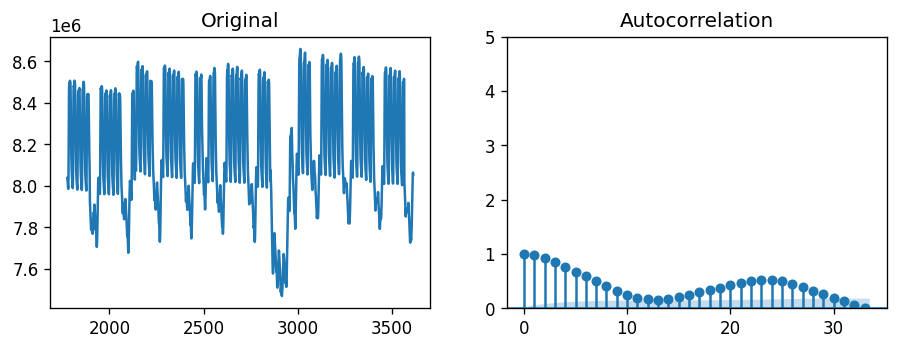

In [68]:
fig, axes= plt.subplots(1,2)
axes[0].plot(spostamenti1[1776:])
axes[0].set_title('Original')

axes[1].set(ylim=(0,5))
plot_acf(spostamenti1[1776:], ax=axes[1])

plt.show()

q sarà uguale a 8-9

In [69]:
train=train.reset_index()
test= test.reset_index()
test.index= test.index+1564

In [70]:
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

In [91]:
# Construct the model
mod = sm.tsa.SARIMAX(train, order=(1,0,3), seasonal_order=(1, 0, 1, 168), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                fp_num   No. Observations:                 1564
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 168)   Log Likelihood              -17796.167
Date:                               Mon, 28 Dec 2020   AIC                          35608.334
Time:                                       14:30:00   BIC                          35651.174
Sample:                                            0   HQIC                         35624.260
                                              - 1564                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.136e+05    2.4e+04      4.735      0.000    6.66e+04    1.61e+05
ar.L1      

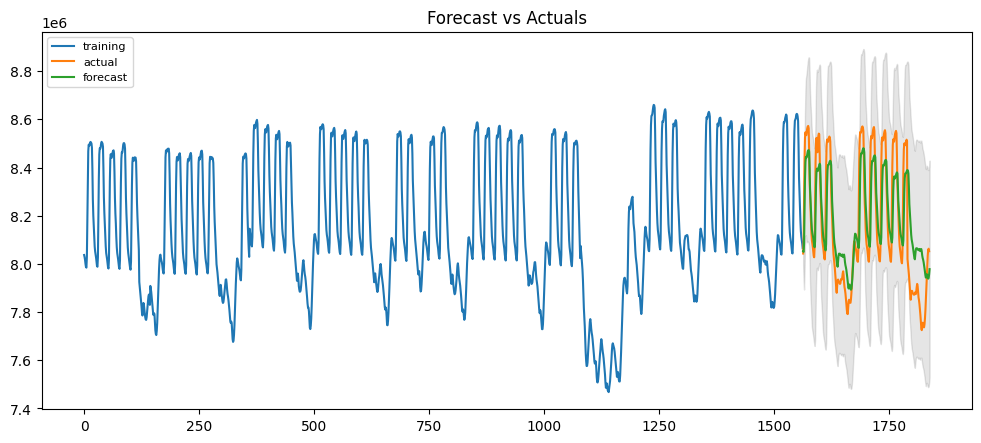

In [92]:
fcast = res.get_forecast(steps=276).summary_frame()

plt.figure(figsize= (12,5), dpi= 100)
plt.plot(train, label='training')
plt.plot(test, label = 'actual')
plt.plot(fcast['mean'], label ='forecast')
plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize= 8)
plt.show()